In [1]:
from pylab import *
import pandas as pd

In [2]:
# data_directory = '../data/'

In [3]:
model_directory = data_directory+'Performance_Models/'

In [4]:
import seaborn as sns
sns.set_style('white')
fig_one_col = 3.4252
fig_two_col = 7.007874
fig_one_point_five_col = 4.488189
from scipy.constants import golden

import pylab
pylab.rcParams['xtick.major.pad']='4'
pylab.rcParams['ytick.major.pad']='4'
pylab.rcParams['figure.subplot.left']='0'
pylab.rcParams['figure.subplot.right']='1'
pylab.rcParams['figure.subplot.bottom']='0'
pylab.rcParams['figure.subplot.top']='1'
pylab.rcParams['savefig.pad_inches']='0'
pylab.rcParams['font.sans-serif']='Arial'

from matplotlib import rc
rc('font', family='sans-serif')
rc('text', usetex=False)
font_size = 7
rc('font', size=font_size)
rc('axes', labelsize=font_size)
rc('ytick', labelsize=font_size)
rc('xtick', labelsize=font_size)
rc('legend', fontsize=font_size)


from matplotlib.font_manager import FontProperties

panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(9.0)
panel_label_font.set_family("sans-serif")

In [5]:
entries = pd.read_hdf(model_directory+'entries_for_performance_analysis.h5', 'entries')

In [6]:
models_store = pd.HDFStore(model_directory+'performance_models.h5')

In [7]:
def load_samples(outcomes, input_data_file, n_chains):

    n_observations = 'full'
    all_samples = {}
    for outcome in outcomes:
        input_data = input_data_file.format(outcome, n_observations)

        all_samples[outcome] = None
        for chain in range(n_chains):
            model = 'stan_samples/{0}/output_{1}_{2}.csv'.format(n_observations, input_data, chain)
            sample = pd.read_csv(model_directory+model, comment='#')
            if all_samples[outcome] is None:
                all_samples[outcome] = sample
            else:
                all_samples[outcome] = all_samples[outcome].append(sample)

    return pd.Panel(all_samples)

def thin_samples(all_samples, target_n_samples):
    n_samples = all_samples.shape[1] 
    sample_thinning_rate = round(n_samples/target_n_samples)
    return all_samples.ix[:,::sample_thinning_rate]

from gc import collect

def prediction_given_R(all_samples, formula_variables, entries, prediction, outcomes):

    from patsy import dmatrix
    entries_new_R = entries.copy()
    formula = " + ".join(formula_variables)
    Rs_to_test = arange(0,1.1,.1)
    
    prediction_given_R = pd.Panel(items=outcomes,
                                  major_axis=arange(all_samples.shape[1]), 
                                  minor_axis=Rs_to_test)

    for R in Rs_to_test:
        print(R)
        entries_new_R['Relatedness'] = R
        predictors = array(dmatrix(formula, entries_new_R))

        
        baseline = '_Mean_for_Year_and_Class_of_New_Immigrants_to_Class'
        pred_dict = {}
        collect()
        
        for outcome in outcomes:   
            print(outcome)
            if 'Agent_Number_of_Citations_per_Patent_in_Class'==outcome:
                continue
            betas = all_samples[outcome][['Intercept']+formula_variables].values
            pred = prediction(predictors,betas.T)
            prediction_given_R.ix[outcome, :, R] = pred.mean(axis=0)
            pred_dict[outcome] = (pred.T*entries[outcome+baseline].values).T
#             print(pred_dict[outcome].shape)
        if 'Agent_Number_of_Citations_per_Patent_in_Class' in outcomes:
            pred = ((pred_dict['Agent_Number_of_Citations_in_Class']/(pred_dict['Agent_Number_of_Patents_in_Class']+1)).T /
                    entries['Agent_Number_of_Citations_per_Patent_in_Class'+baseline].values).T.mean(axis=0)
#             print(pred.shape)
            prediction_given_R.ix['Agent_Number_of_Citations_per_Patent_in_Class', :, R] = pred
            collect()
    quantiles_for_prediction = [.025, .5, .975]
    prediction_quantiles_given_R = pd.Panel(items=prediction_given_R.items,
                                            major_axis = quantiles_for_prediction,
                                            minor_axis = prediction_given_R.minor_axis
                                            )
    for item in prediction_quantiles_given_R.items:
        prediction_quantiles_given_R[item] = prediction_given_R[item].quantile(quantiles_for_prediction)

    return prediction_quantiles_given_R

def model_figures(all_samples,
                  formula_variables,
                  prediction_quantiles_given_R,
                 outcome_label,
                 legend_title,
                 additional_variables=[]):
    
    fig = figure(figsize=(fig_three_col, fig_three_col*golden))

    beta_columns = [x for x in all_samples.minor_axis if x.startswith('beta')]
    if additional_variables:
        beta_columns+=additional_variables
        formula_variables+=additional_variables
    outcomes = all_samples.items
    
    n_rows = len(beta_columns)+1
    n_cols = 1
    this_ax = 0

    from scipy.stats import scoreatpercentile
    from bisect import bisect_left

    var_i = 0
    for col in beta_columns:
        this_ax +=1
        ax = fig.add_subplot(n_rows, n_cols, this_ax)
        for outcome in outcomes:
            label = '{0}'.format(outcome).replace('_',' ')
            p = sns.kdeplot(all_samples[outcome][col], ax=ax, label=label, legend=False)
            p = p.get_lines()[-1]
            x,y = p.get_data()
            c = p.get_color()
            lower = scoreatpercentile(all_samples[outcome][col], 2.5)
            upper = scoreatpercentile(all_samples[outcome][col], 97.5)
            lower_ind = bisect_left(x,lower)
            upper_ind = bisect_left(x,upper) 
            ax.fill_between(x[lower_ind:upper_ind], y[lower_ind:upper_ind], alpha=.4, color=c)
        if var_i==0:
            col_label = 'Intercept'
        else:
            col_label = formula_variables[var_i-1]
        var_i+=1
        ax.set_xlabel(col_label)
        ax.set_yticks([])
        if this_ax==1:
            legend(loc='best',ncol=4, title=legend_title)
    fig.tight_layout()
    
    fig = figure(figsize=(fig_three_col, fig_three_col*golden))

    n_rows = ceil(sqrt(len(outcomes)))
    n_cols = floor(len(outcomes)/n_rows)
    this_ax = 0

    for outcome in outcomes:
        this_ax +=1
        ax = fig.add_subplot(n_rows, n_cols, this_ax)        
        ax.fill_between(prediction_quantiles_given_R.minor_axis, 
                        prediction_quantiles_given_R[outcome,.025],
                        prediction_quantiles_given_R[outcome,.975],
                        alpha=.2)
        ax.plot(prediction_quantiles_given_R.minor_axis,
                prediction_quantiles_given_R[outcome,.5])
        ax.set_xlabel('R')
        ax.set_ylabel(outcome_label)
        ax.set_title(outcome)

In [8]:
outcomes = ['Agent_Number_of_Patents_in_Class', 'Agent_Number_of_Citations_in_Class']
input_data_file = 'counts_data_{0}_{1}.stan'
n_chains = 50
hdf_label = 'counts'
formula_variables = models_store['%s/formula_variables'%hdf_label].tolist()

legend_title = 'Inventor Performance'
outcome_label = '% Increase Compared to\nOther Explorers Entering the Same Domain in the Same Year'

def posterior_prediction_mean(predictors, parameters):
    return exp(dot(predictors, parameters).astype('float64'))

from scipy.stats import nbinom
def draw_from_negative_binomial(mu, phi):
    n = phi
    p = 1/(1+mu/phi)
    return nbinom.rvs(n, p)

def posterior_prediction_draw(entries, formula_variables, parameters, outcome):
    from patsy import dmatrix
    formula = " + ".join(formula_variables)
    predictors = array(dmatrix(formula, entries))
        
    mu = exp((dot(predictors, parameters[['Intercept']+formula_variables].T)))
    phi = parameters['phi'].values

    baseline = entries[outcome+'_Mean_for_Year_and_Class_of_New_Immigrants_to_Class']
    mu *= atleast_2d(baseline.values).T
    
    return draw_from_negative_binomial(mu,phi)

### Load samples and thin
all_samples = load_samples(outcomes, input_data_file, n_chains)
beta_columns = [x for x in all_samples.minor_axis if x.startswith('beta')]
all_samples.rename(minor_axis=dict(zip(beta_columns, ['Intercept']+formula_variables)), inplace=True)
thinned_samples = thin_samples(all_samples, 500)
models_store['%s/model_samples'%hdf_label] = all_samples
models_store['%s/model_samples_thinned'%hdf_label] = thinned_samples


### Show how average prediction changes with R
prediction_quantiles_given_R = prediction_given_R(thinned_samples, formula_variables, 
                                                  entries, posterior_prediction_mean, 
                                                  outcomes+['Agent_Number_of_Citations_per_Patent_in_Class'])
models_store['%s/prediction_quantiles_given_R'%hdf_label] = prediction_quantiles_given_R

# model_figures(all_samples,
#                   formula_variables,
#                   prediction_quantiles_given_R,
#              outcome_label,
#                  legend_title,additional_variables=['phi'])

0.0
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.1
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.2
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.3
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.4
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.5
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.6
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.7
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.8
Agent_Number_of_Patents_in_Class
Agent_Number_of_Cit

In [ ]:
### Do posterior prediction checking
within_95CI = {}
for outcome in outcomes:
    print(outcome)
    ppd = posterior_prediction_draw(entries, formula_variables, thinned_samples[outcome], outcome)
    lower = percentile(ppd, 2.5, axis=1)
    upper = percentile(ppd, 97.5, axis=1)
    within_95CI[outcome] = mean((lower <= entries[outcome].values) * 
                                (entries[outcome].values<= upper)
                               )
    print(within_95CI[outcome])
models_store['%s/within_95CI'%hdf_label] = pd.Series(within_95CI)

In [8]:
###Joint outputs modeling
outcomes = ['Agent_Number_of_Patents_in_Class', 'Agent_Number_of_Citations_in_Class']
input_data_file = 'counts_data_{0}_{1}.stan'
n_chains = 0
hdf_label = 'joint_counts'
formula_variables = models_store['%s/formula_variables'%hdf_label].tolist()

legend_title = 'Inventor Performance'
outcome_label = '% Increase Compared to\nOther Explorers Entering the Same Domain in the Same Year'

def posterior_prediction_mean(predictors, parameters):
    return exp(dot(predictors, parameters).astype('float64'))

from scipy.stats import nbinom
def draw_from_negative_binomial(mu, phi):
    n = phi
    p = 1/(1+mu/phi)
    return nbinom.rvs(n, p)

def posterior_prediction_draw(entries, formula_variables, parameters, outcome):
    from patsy import dmatrix
    formula = " + ".join(formula_variables)
    predictors = array(dmatrix(formula, entries))
        
    mu = exp((dot(predictors, parameters[['Intercept']+formula_variables].T)))
    phi = parameters['phi'].values

    baseline = entries[outcome+'_Mean_for_Year_and_Class_of_New_Immigrants_to_Class']
    mu *= atleast_2d(baseline.values).T
    
    return draw_from_negative_binomial(mu,phi)

### Load samples and thin
joint_samples = load_samples(['Joint'], input_data_file, 1)
all_samples = {}
all_samples['Agent_Number_of_Patents_in_Class'] = joint_samples.ix[0,:,[x.endswith('.1') for x in joint_samples.minor_axis]]
renames = {}
for x in all_samples['Agent_Number_of_Patents_in_Class'].columns:
    renames[x] = x[:-2]
all_samples['Agent_Number_of_Patents_in_Class'].rename(columns=renames, inplace=True)
all_samples['Agent_Number_of_Citations_in_Class'] = joint_samples.ix[0,:,[x.endswith('.2') for x in joint_samples.minor_axis]]
renames = {}
for x in all_samples['Agent_Number_of_Citations_in_Class'].columns:
    renames[x] = x[:-2]
all_samples['Agent_Number_of_Citations_in_Class'].rename(columns=renames, inplace=True)
all_samples = pd.Panel(all_samples)
beta_columns = [x for x in all_samples.minor_axis if x.startswith('beta')]
all_samples.rename(minor_axis=dict(zip(beta_columns, ['Intercept']+formula_variables)), inplace=True)
thinned_samples = thin_samples(all_samples, 500)
models_store['%s/model_samples'%hdf_label] = all_samples
models_store['%s/model_samples_thinned'%hdf_label] = thinned_samples

### Show how average prediction changes with R
prediction_quantiles_given_R = prediction_given_R(thinned_samples, formula_variables, 
                                                  entries, posterior_prediction_mean, 
                                                  outcomes+['Agent_Number_of_Citations_per_Patent_in_Class'])
models_store['%s/prediction_quantiles_given_R'%hdf_label] = prediction_quantiles_given_R

# model_figures(all_samples,
#                   formula_variables,
#                   prediction_quantiles_given_R,
#              outcome_label,
#                  legend_title,additional_variables=['phi'])

0.0
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.1
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.2
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.3
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.4
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.5
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.6
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.7
Agent_Number_of_Patents_in_Class
Agent_Number_of_Citations_in_Class
Agent_Number_of_Citations_per_Patent_in_Class
0.8
Agent_Number_of_Patents_in_Class
Agent_Number_of_Cit

In [13]:
def model_parameters(all_samples, formula_variables, formula_variables_labels,
                     legend_title, legend_labels=None):
    fig = figure(figsize=(fig_two_col, fig_two_col*golden))

    outcomes = all_samples.items
    
    n_rows = len(formula_variables)
    n_cols = 1
    this_ax = 0

    from scipy.stats import scoreatpercentile
    from bisect import bisect_left

    var_i = 0
    for col in formula_variables:
        this_ax +=1
        ax = fig.add_subplot(n_rows, n_cols, this_ax)
        for outcome in outcomes:
            if legend_labels is None:
                label = '{0}'.format(outcome).replace('_',' ')
            else:
                label = legend_labels[outcome]
            p = sns.kdeplot(all_samples[outcome][col], ax=ax, label=label, legend=False)
            p = p.get_lines()[-1]
            x,y = p.get_data()
            c = p.get_color()
            lower = scoreatpercentile(all_samples[outcome][col], 2.5)
            upper = scoreatpercentile(all_samples[outcome][col], 97.5)
            lower_ind = bisect_left(x,lower)
            upper_ind = bisect_left(x,upper) 
            ax.fill_between(x[lower_ind:upper_ind], y[lower_ind:upper_ind], alpha=.4, color=c)
        col_label = formula_variable_labels[col]
        var_i+=1
        ax.set_xlabel(col_label)
        ax.set_yticks([])
        if ax.get_xlim()[0]<=0 and ax.get_xlim()[1]>=0:
            ax.axvline(0, color='black', linestyle='--', linewidth=.5)
        if this_ax==1:
            legend(loc='best',ncol=4, title=legend_title)
#     fig.tight_layout()
    
    sns.despine(left=True)
#     fig.tight_layout()
    return fig

In [14]:
formula_variable_labels = {'Intercept': r"$\beta$ for Intercept (Constant)",
                           'Relatedness':r"$\beta$ for $R$ of Domain Entered to Inventor's Previous Domains",
                          'np.power(Relatedness, 2)':r'$\beta$ for $R^2$',
                          'Popularity':r'$\beta$ for Popularity of Entered Domain (# of Patents in Domain in Previous Year)',                                               
                          'np.power(Popularity, 2)':r'$\beta$ for Popularity$^2$',
                          'log(Agent_Previous_Citations_to_Class+1)':r"$\beta$ for ln(Inventor's # of Previous Citations to Domain + 1)",
                          'log(CoAgent_Previous_Patent_Count_in_Class+1)':r"$\beta$ for ln(Inventor's Co-Author's # of Previous Patents in Domain + 1)",
                          'log(Agent_Productivity_Patents)':r"$\beta$ for ln(Inventor's # of Patents/Year)",
                           'phi': '$\phi$',
                           'Guided': r"$\beta$ for Whether Explorer had a Guide on their Entering Patent",
                           'log(N_Agents)': r"$\beta$ for ln(# of Co-Authors on Entering Patent + 1)"
                          }

In [15]:
thinned_samples = thinned_samples.sort_index(axis=0, ascending=False)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


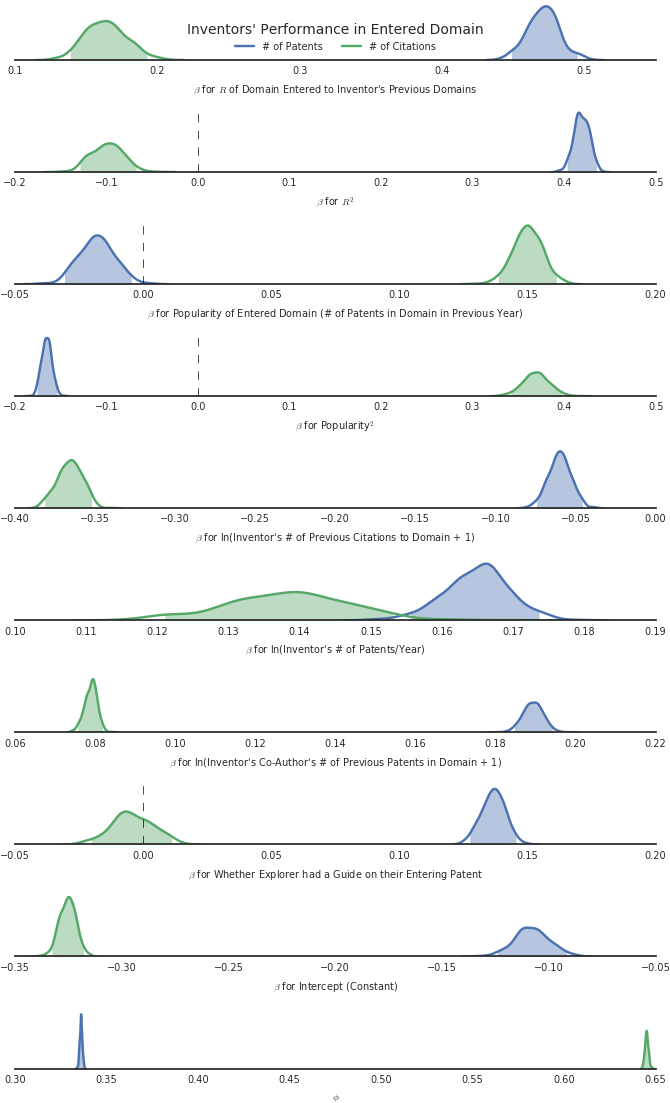

In [18]:
fig = model_parameters(thinned_samples,
                  formula_variables[:-1]+['Intercept', 'phi'],
                  formula_variable_labels,
                 "Inventors' Performance in Entered Domain",
                       legend_labels={'Agent_Number_of_Patents_in_Class': '# of Patents',
                                      'Agent_Number_of_Citations_in_Class': '# of Citations',
                                     })#,additional_variables=['phi'])
fig.tight_layout()

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


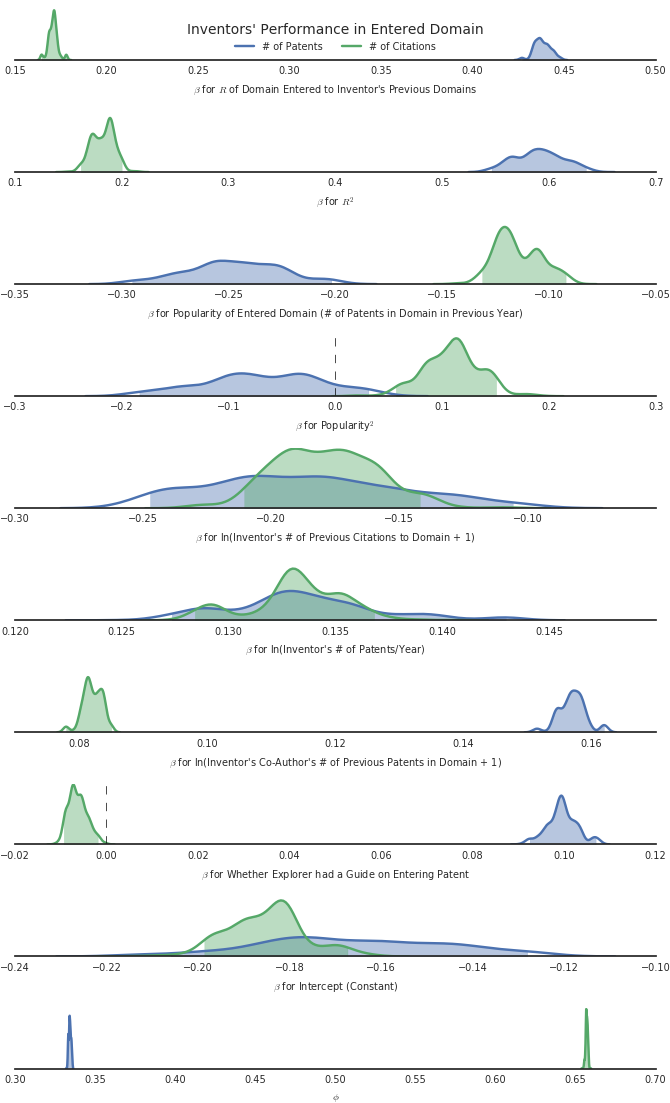

In [17]:
fig = model_parameters(thinned_samples,
                  formula_variables[:-1]+['Intercept', 'phi'],
                  formula_variable_labels,
                 "Inventors' Performance in Entered Domain",
                       legend_labels={'Agent_Number_of_Patents_in_Class': '# of Patents',
                                      'Agent_Number_of_Citations_in_Class': '# of Citations',
                                     })#,additional_variables=['phi'])
fig.tight_layout()

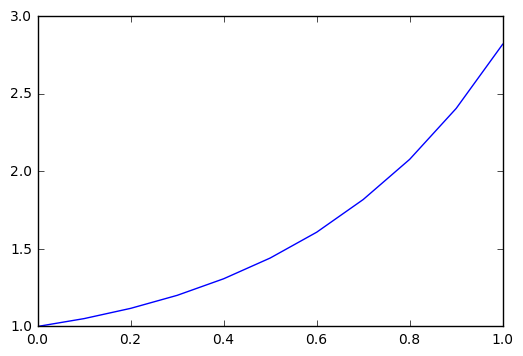

In [15]:
(prediction_quantiles_given_R['Agent_Number_of_Patents_in_Class'].ix[.5]/prediction_quantiles_given_R['Agent_Number_of_Patents_in_Class'].ix[.5].iloc[0]).plot()

In [33]:
def prediction_given_R(all_samples, formula_variables, entries, prediction, outcomes):

    from patsy import dmatrix
    entries_new_R = entries.copy()
    formula = " + ".join(formula_variables)
    Rs_to_test = arange(0,1.1,.1)
    
    prediction_given_R = pd.Panel(items=outcomes,
                                  major_axis=arange(all_samples.shape[1]), 
                                  minor_axis=Rs_to_test)

    for R in Rs_to_test:
        print(R)
        entries_new_R['Relatedness'] = R
        predictors = array(dmatrix(formula, entries_new_R))

        for outcome in outcomes:   
            print(outcome)
            betas = all_samples[outcome][['Intercept']+formula_variables].values
            prediction_given_R.ix[outcome, :, R] = prediction(predictors,betas.T).mean(axis=0)


    quantiles_for_prediction = [.025, .5, .975]
    prediction_quantiles_given_R = pd.Panel(items=prediction_given_R.items,
                                            major_axis = quantiles_for_prediction,
                                            minor_axis = prediction_given_R.minor_axis
                                            )
    for item in prediction_quantiles_given_R.items:
        prediction_quantiles_given_R[item] = prediction_given_R[item].quantile(quantiles_for_prediction)

    return prediction_quantiles_given_R

In [34]:
outcomes = [3,4,5,6]
input_data_file = 'hits_data_thr_{0}_{1}.stan'
n_chains = 5
hdf_label = 'hits'
formula_variables = models_store['%s/formula_variables'%hdf_label].tolist()
legend_title = 'Z-Score Threshold'
outcome_label = 'p(Hit)'

from scipy.special import expit
def posterior_prediction_mean(predictors, parameters):
    return expit(dot(predictors, parameters).astype('float64'))
# def posterior_prediction(entries, formula_variables, parameters, outcome):
#     from patsy import dmatrix
#     formula = " + ".join(formula_variables)
#     predictors = array(dmatrix(formula, entries))
#     return expit((dot(predictors, parameters[['Intercept']+formula_variables].T)))

### Load samples and thin
all_samples = load_samples(outcomes, input_data_file, n_chains)
beta_columns = [x for x in all_samples.minor_axis if x.startswith('beta')]
all_samples.rename(minor_axis=dict(zip(beta_columns, ['Intercept']+formula_variables)), inplace=True)
thinned_samples = thin_samples(all_samples, 500)
models_store['%s/model_samples'%hdf_label] = all_samples
models_store['%s/model_samples_thinned'%hdf_label] = thinned_samples

### Show how average prediction changes with R
prediction_quantiles_given_R = prediction_given_R(thinned_samples, formula_variables, 
                                                  entries, posterior_prediction_mean, outcomes)
models_store['%s/prediction_quantiles_given_R'%hdf_label] = prediction_quantiles_given_R

# model_figures(all_samples,
#                   formula_variables,
#                   prediction_quantiles_given_R)

0.0
3
4
5
6
0.1
3
4
5
6
0.2
3
4
5
6
0.3
3
4
5
6
0.4
3
4
5
6
0.5
3
4
5
6
0.6
3
4
5
6
0.7
3
4
5
6
0.8
3
4
5
6
0.9
3
4
5
6
1.0
3
4
5
6


In [20]:
models_store.close()